In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from tensorflow.keras import utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [5]:
# omogucava da se koriste funkcije iz sveske SharedFunctions

%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

In [5]:
# data.head()

### 1. Podela na trening, test, i validacioni skup

In [6]:
X = data['comment_text']
y = data['target']

In [7]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [8]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [9]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Priprema teksta

Usaglašavaju se dužine komentara. Ograničavamo se na prvih 100 reči komentara (dopunjava se nulama ako je kraći od 100 reči).  
Naglašava se i veličina vokabulara. Pretpostavka je da je dovoljno ograničiti se na prvih 20000 reči vokabulara.

In [10]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [11]:
# Funkcija kreira tokenizator (Kerasov Tokenizer) koji izdvaja reči teksta,
# zatim ga fituje ga na trening skupu i konstruiše vokabular reči (word_index) dužine max_features
# Dodatno, čuva tokenizer kao pickle fajl

word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [12]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [13]:
# funkcija to_sequence pretvara tekst u sekvence i svodi sve komentare na duzinu max_len

X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)
X_train_validation_transformed = to_sequence(X_train_validation, max_len, tokenizer)

In [14]:
# X_train_transformed

Za predstavljanje reči koristimo ugnježdavanja u semantički prostor pomoću Embedding sloja.
Mreža će koristiti pritrenirane ugnježđene reprezentacije - GloVe reprezentacije. Korišćene su reprezentacije dužine 100 koje se nalaze u datoteci glove.6B.100d.txt.
Mapiramo komentare u reči, a zatim reči u vektorske reprezentacije.
Kreira se matrica ugnježdavanja na osnovu dobijenog vokabulara i GloVe vrednosti: 

In [15]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)

In [16]:
embedding_matrix.shape

(20000, 100)

### 3. Selekcija i evaluacija modela

Pošto su klase nebalansirane, potrebno je dodeliti im težine tako da se više kažnjava pogrešna klasifikacija manjinske klase:

In [17]:
weights = get_weights(y_train_validation, 2)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i omotač KerasClassifier 

Linije su zakomentarisane jer se predugo izvršava, rezultati su sačuvani u csv fajl

In [18]:
# random_cv = randomized_search_cv(X_train_validation_transformed, y_train_validation, weights, embedding_matrix, 2)

In [19]:
# best_params = random_cv.best_params_
# best_score = random_cv.best_score_
# results = random_cv.cv_results_

In [20]:
# cv_data = pd.DataFrame(results)
# cv_data.to_csv('data/cv_results.csv')

In [21]:
cv_results = pd.read_csv('data/cv_results.csv')

In [22]:
# cv_results.head()

In [23]:
best = cv_results[cv_results['rank_test_score']==1]

### 4. Formiranje modela

In [24]:
kernel_size = (best['param_kernel_size'].values[0], )
pool_size = (best['param_pool_size'].values[0], )
filters = best['param_filters'].values[0]
dropout_rate = best['param_dropout_rate'].values[0]
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)
lr = best['param_lr'].values[0]
layers = best['param_layers'].values[0]

In [25]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           33024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 256)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0

### 5. Obučavanje modela

In [26]:
epochs = 12
batch_size = 128

In [27]:
start = time.time()    

binary_history = binary_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation_transformed, y_validation), class_weight=weights)
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/12
936/936 [==============================] - 26s 25ms/step - loss: 0.4592 - precision: 0.3270 - recall: 0.7708 - auc: 0.8807 - f1_m: 0.4504 - val_loss: 0.3442 - val_precision: 0.4245 - val_recall: 0.8589 - val_auc: 0.9345 - val_f1_m: 0.5613
Epoch 2/12
936/936 [==============================] - 26s 28ms/step - loss: 0.3246 - precision: 0.4403 - recall: 0.8581 - auc: 0.9378 - f1_m: 0.5765 - val_loss: 0.3139 - val_precision: 0.4609 - val_recall: 0.8685 - val_auc: 0.9432 - val_f1_m: 0.59480 - recall: 0.8591 
Epoch 3/12
936/936 [==============================] - 20s 21ms/step - loss: 0.3063 - precision: 0.4683 - recall: 0.8666 - auc: 0.9446 - f1_m: 0.6025 - val_loss: 0.3096 - val_precision: 0.4726 - val_recall: 0.8751 - val_auc: 0.9472 - val_f1_m: 0.6060
Epoch 4/12
936/936 [==============================] - 19s 21ms/step - loss: 0.2950 - precision: 0.4859 - recall: 0.8709 - auc: 0.9488 - f1_m: 0.6183 - val_loss: 0.3025 - val_precision: 0.4845 - val_recall: 0.8811 - val_auc: 0.9501 

Prate se preciznost, odziv, funkcija gubitka, F1 mera i AUC (jer klase nisu izbalansirane)

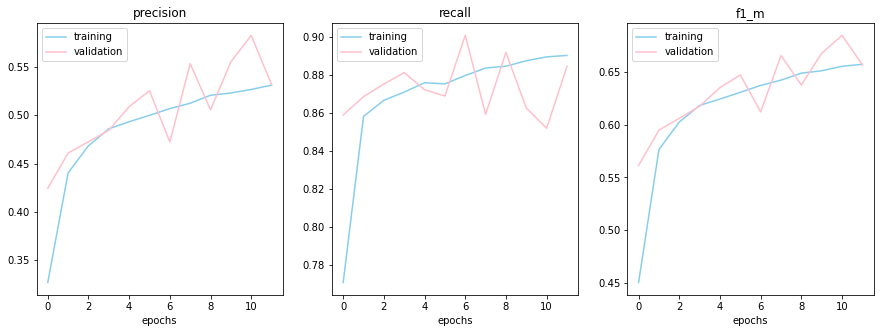

In [28]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['precision', 'recall', 'f1_m'])

### 6. Evaluacija modela

Evaluacija se radi i na trening skupu radi praćenja preprilagođavanja, a zatim i na testu

In [29]:
scores = binary_model.evaluate(X_train_transformed, y_train)
print('Loss train: ', scores[0])
print('Train precision: ', scores[1])
print('Train recall: ', scores[2])
print('Train auc: ', scores[3])
print('Train F1: ', scores[4])

3743/3743 [==============================] - 13s 4ms/step - loss: 0.2545 - precision: 0.5429 - recall: 0.8930 - auc: 0.9632 - f1_m: 0.6424
Loss train:  0.25454288721084595
Train precision:  0.542911946773529
Train recall:  0.8929668664932251
Train auc:  0.9632384181022644
Train F1:  0.6424403190612793


In [30]:
scores = binary_model.evaluate(X_test_transformed, y_test)
print('Loss: ', scores[0])
print('Test precision: ', scores[1])
print('Test recall: ', scores[2])
print('Test auc: ', scores[3])
print('F1: ', scores[4])

2305/2305 [==============================] - 8s 4ms/step - loss: 0.2612 - precision: 0.5308 - recall: 0.8740 - auc: 0.9556 - f1_m: 0.6264
Loss:  0.2611629366874695
Test precision:  0.5308429598808289
Test recall:  0.8740221261978149
Test auc:  0.9556222558021545
F1:  0.6264176964759827


Predviđanje: 

In [31]:
y_predicted = binary_model.predict(X_test_transformed)

In [32]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [33]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[60599  5727]
 [  934  6480]]


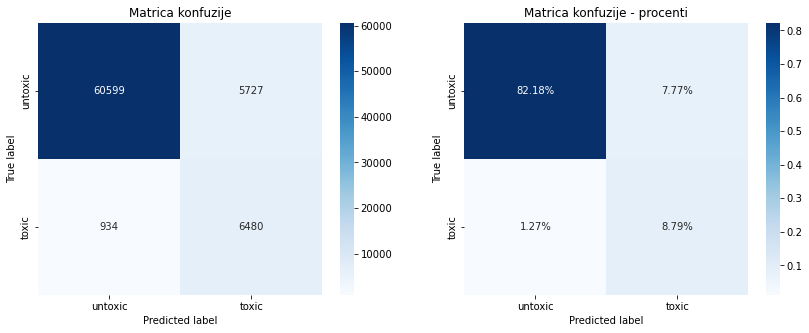

In [34]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

#### - Od oko 90% procenata netoksičnih, 82.18% je tačno klasifikovano(TN), a 7.77% netačno(FP)
#### - Od oko 10% procenata toksičnih komentara, 8.79% je tačno klasifikovano(TP), a 1.27% netačno(FN)

In [48]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.91      0.95     66326
           1       0.53      0.87      0.66      7414

    accuracy                           0.91     73740
   macro avg       0.76      0.89      0.80     73740
weighted avg       0.94      0.91      0.92     73740



Cilj je **maksimizovati odziv**, odnosno treba da bude što manji broj lažno negativnih - važnije je da se pronađu toksični komentari. Manja je šteta ako neki netoksičan bude klasifikovan kao toksičan, nego obrnuto. Preciznost za pozitivnu klasu od 0.5 je u ovom slučaju u redu, jer broj lažno pozitivnih je samo mali deo velikog broja instanci negativne klase (netoksičnih komentara).

Izdvajanje instanci na kojima model greši:

In [49]:
joined = pd.concat([X_test, y_test], axis=1)
joined['predicted'] = y_labels

In [50]:
correct = joined[joined['target'] == joined['predicted']]
incorrect = joined[joined['target'] != joined['predicted']]

Primeri pogresno klasifikovanih komentara:

In [51]:
# pogresno klasifikovane instance: 
incorrect.head()

,comment_text,target,predicted
72935,possibly the worst ever adaptation of a comic ...,0,1
83588,hi i am trying to get breasts like yours but ...,0,1
132027,hornswoggle joining club hornswoggle joined ...,1,0
104940,my i ask why you have personally attacked me,0,1
166794,flickrcom here are a random selection of t...,0,1


In [52]:
# FN -> toksicni koji su klasifikovani kao netoksicni
FN = (incorrect['target']==1) & (incorrect['predicted']==0)

# FP -> netoksicni koji su klasifikovani kao toksicni
FP = (incorrect['target']==0) & (incorrect['predicted']==1)

In [53]:
# incorrect[FP]['comment_text'].head()
# incorrect[FN]['comment_text'].tail()

In [56]:
indexes = incorrect[FP].index
random_index = np.random.choice(indexes)

# primer jednog nasumicnog netoksicnog koji je model obelezio kao toksican komentar

print('Primer lažno pozitivne instance: ')
incorrect[FP]['comment_text'][random_index]

Primer lažno pozitivne instance: 


'warning  chris is a known child abuser and has been using wikipedia and the internet for this purpose'

In [57]:
# primer nasumicnog toksicnog koji je model obelezio kao netoksican
indexes = incorrect[FN].index
random_index = np.random.choice(indexes)

print('Primer lažno negativne instance: ')
incorrect[FN]['comment_text'][random_index]

Primer lažno negativne instance: 


'the elephant population has tripled over the last decade   i am not particularly fond of your level of douchebag'

U direktorijumu **plots and images/prediction_examples/** se nalaze skrinšotovi nekoliko zanimljivih izlaza prethodnih naredbi, 
na osnovu kojih se može zaključiti da model greši u slučaju greški u kucanju, u slučaju kada su reči napisane slovo po slovo sa razmacima između i slično. U slučaju lažno pozitivnih instanci - model predviđa komentar kao toksičan ako ima ružnih reči, a neki takvi komentari su ipak netoksični. Po mom mišljenju, neki od ovih komentara bi trebalo da budu toksični u originalnom skupu. 

Ovakvo ponašanje je očekivano, što znači da model u većini slučajeva dobro zaključuje. 

Ono što se može uraditi za bolja predviđanja je detaljnija priprema teksta, sređivanje komentara sa koji su pogrešno spelovani, spajanje u jednu reč ako ima nekoliko uzastopnih pojedinačnih slova sa razmacima izmeđi i slično.

Proba na novim podacima (kratke rečenice)

In [61]:
# nekoliko jednostavnih provera za uvredljive, obicne komentare, namerno pogresno spelovane...
new_comments = ['fuck you bitch', 
                'fukc you', 
                'hello i have a question about something', 
                'shit head', 
                'shithead',
                'this is a clean comment', 
                'get out of here',
                's h i t',
                'you are so stupid']

new = to_sequence(new_comments, max_len, tokenizer)

In [68]:
# verovatnoce pripadanja toksicnim:

probs = binary_model.predict(new)
toxic_probs = {}
i = 0
for comment in new_comments:
    toxic_probs[comment] = round(probs[i][0], 3)
    i += 1

In [69]:
print('Verovatnoca pripadanja komentara klasi toksicnih: ')
toxic_probs

Verovatnoca pripadanja komentara klasi toksicnih: 


{'fuck you bitch': 0.999,
 'fukc you': 0.567,
 'hello i have a question about something': 0.188,
 'shit head': 0.997,
 'shithead': 0.289,
 'this is a clean comment': 0.305,
 'get out of here': 0.383,
 's h i t': 0.213,
 'you are so stupid': 0.994}

Od ovih primera, model pogrešno predviđa jedino za dva komentara koja su pogrešno napisana, pa se za njih ne može zaključiti da su u pitanju uvredljive reči.

### Čuvanje modela

In [ ]:
binary_model.save_weights('models/binary_model_weights.h5')
binary_model.save('models/binary_model.h5')

In [8]:
#model = keras.models.load_model('models/binary_model.h5', custom_objects={"f1_m": f1_m})
#utils.plot_model(model, to_file='plots and images/binary_model.png', show_shapes=True)
# model.get_config()